In [ ]:
import os
print(os.getcwd())

In [ ]:
!pip install -r requirements.txt --user

In [ ]:
!pip install git+https://github.com/haven-jeon/PyKoSpacing.git --user

In [ ]:
!pip install git+https://github.com/ssut/py-hanspell.git --user

In [8]:
import pandas as pd
from collections import Counter
import warnings
warnings.filterwarnings(action='ignore')
import re
from tqdm.notebook import tqdm
from IPython.core.display import HTML
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pickle
import numpy
import os
# Import mallet packages
from gensim.models.wrappers import LdaMallet
from gensim.models.wrappers.ldamallet import malletmodel2ldamodel
from gensim import corpora
from gensim.models import CoherenceModel
from pprint import pprint

In [9]:
data = pd.read_excel("./files/먹방_crawling.xlsx")
data.head(10)

,Unnamed: 0,title,channelName,length,views,date
0,0,Mukbang 짜장면 떡볶이 편의점 먹방 Convenience Store Food ...,DONA 도나,2:54,조회수 2.3억회,9개월 전
1,1,Mukbang Bottle Candy Jelly 컬러 보틀 젤리 우유병 먹방 DON...,DONA 도나,2:19,조회수 1.9억회,9개월 전
2,2,Mukbang Spicy Giant Seafood 대왕 해산물 먹방 DONA 도나,DONA 도나,8:51,조회수 1.8억회,8개월 전
3,3,짜장면 떡볶이 먹방 Black Noodle TTeokbokki Mukbang DON...,DONA 도나,2:42,조회수 1.5억회,9개월 전
4,4,명화 먹방 Famous painting MUkbang 모나리자 Mona Lisa,HappyBomBom 해피봄봄,2:02,조회수 1.2억회,8개월 전
5,5,TikTok Challenge ASMR Drink 틱톡 챌린지 먹방 DONA 도나,DONA 도나,3:35,조회수 1.1억회,6개월 전
6,6,Mukbang 짜파게티 떡볶이 먹방 Black Noodle TTeokbokki DO...,DONA 도나,3:36,조회수 9896만회,8개월 전
7,7,How to Make Kyoho Jelly 쿄호젤리 만들기 먹방 Mukbang DO...,DONA 도나,2:50,조회수 8356만회,9개월 전
8,8,불닭볶음면 먹방 Mukbang Spicy Noodle DONA 도나,DONA 도나,10:30,조회수 8184만회,4개월 전
9,9,Red VS Green Ice Cream Mukbang 빨간색 초록색 아이스크림 먹...,DONA 도나,2:58,조회수 7158만회,11개월 전


In [10]:
titles = data['title']
titles = pd.DataFrame(titles)

In [11]:
# titles = titles.reindex(['title'],axis =1 )

In [12]:
titles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   120 non-null    object
dtypes: object(1)
memory usage: 1.1+ KB


In [13]:
titles.isnull().sum()

title    0
dtype: int64

In [14]:
titles = titles.dropna().reset_index(drop = True)
titles.head()

,title
0,Mukbang 짜장면 떡볶이 편의점 먹방 Convenience Store Food ...
1,Mukbang Bottle Candy Jelly 컬러 보틀 젤리 우유병 먹방 DON...
2,Mukbang Spicy Giant Seafood 대왕 해산물 먹방 DONA 도나
3,짜장면 떡볶이 먹방 Black Noodle TTeokbokki Mukbang DON...
4,명화 먹방 Famous painting MUkbang 모나리자 Mona Lisa


In [15]:
def clean_text(text):
    '''
    Only Korean, English, and numbers are left.
    '''
    text = text.replace(".", " ").rstrip()
    text = re.sub(r'(https?://[^\s]+)', ' ', text)
    text = re.sub('[^가-힣|0-9|a-zA-Z]+', ' ', text)
    text = re.sub(' +', ' ', text)
    return text

In [16]:
titles['cleaned_text'] = ""
titles

,title,cleaned_text
0,Mukbang 짜장면 떡볶이 편의점 먹방 Convenience Store Food ...,
1,Mukbang Bottle Candy Jelly 컬러 보틀 젤리 우유병 먹방 DON...,
2,Mukbang Spicy Giant Seafood 대왕 해산물 먹방 DONA 도나,
3,짜장면 떡볶이 먹방 Black Noodle TTeokbokki Mukbang DON...,
4,명화 먹방 Famous painting MUkbang 모나리자 Mona Lisa,
...,...,...
115,"리얼먹방:) 엽떡 로제떡볶이 ★ ft. 주먹밥, 핫도그ㅣRose Sauce Tteo...",
116,리얼먹방:) 쌀쌀할땐 꽃게탕 !! ★ ft. 붕어싸만코ㅣKkotge-tang (Sp...,
117,ASMR MUKBANG| 편의점 직접 만든 핵불닭 떡볶이 치킨 김밥 디저트 먹방 &...,
118,SUB)2주년 기념 딸기가득 딸기케이크 먹방!🥳🎂🍓수저로 마구마구 퍼먹기(ft.호두...,


In [17]:
for i in tqdm(range(len(titles))):
    titles['cleaned_text'][i] = clean_text(titles['title'][i])

  0%|          | 0/120 [00:00<?, ?it/s]

In [18]:
%%time 
titles['cleaned_text'] = titles['title'].apply(lambda x: clean_text(x))

Wall time: 1.99 ms


In [19]:
titles = titles[(titles['cleaned_text']!= "") & (titles['cleaned_text']!= " ")]
titles = titles.reset_index(drop = True)

In [20]:
titles

,title,cleaned_text
0,Mukbang 짜장면 떡볶이 편의점 먹방 Convenience Store Food ...,Mukbang 짜장면 떡볶이 편의점 먹방 Convenience Store Food ...
1,Mukbang Bottle Candy Jelly 컬러 보틀 젤리 우유병 먹방 DON...,Mukbang Bottle Candy Jelly 컬러 보틀 젤리 우유병 먹방 DON...
2,Mukbang Spicy Giant Seafood 대왕 해산물 먹방 DONA 도나,Mukbang Spicy Giant Seafood 대왕 해산물 먹방 DONA 도나
3,짜장면 떡볶이 먹방 Black Noodle TTeokbokki Mukbang DON...,짜장면 떡볶이 먹방 Black Noodle TTeokbokki Mukbang DON...
4,명화 먹방 Famous painting MUkbang 모나리자 Mona Lisa,명화 먹방 Famous painting MUkbang 모나리자 Mona Lisa
...,...,...
115,"리얼먹방:) 엽떡 로제떡볶이 ★ ft. 주먹밥, 핫도그ㅣRose Sauce Tteo...",리얼먹방 엽떡 로제떡볶이 ft 주먹밥 핫도그 Rose Sauce Tteokbokki...
116,리얼먹방:) 쌀쌀할땐 꽃게탕 !! ★ ft. 붕어싸만코ㅣKkotge-tang (Sp...,리얼먹방 쌀쌀할땐 꽃게탕 ft 붕어싸만코 Kkotge tang Spicy Blue ...
117,ASMR MUKBANG| 편의점 직접 만든 핵불닭 떡볶이 치킨 김밥 디저트 먹방 &...,ASMR MUKBANG| 편의점 직접 만든 핵불닭 떡볶이 치킨 김밥 디저트 먹방 레...
118,SUB)2주년 기념 딸기가득 딸기케이크 먹방!🥳🎂🍓수저로 마구마구 퍼먹기(ft.호두...,SUB 2주년 기념 딸기가득 딸기케이크 먹방 수저로 마구마구 퍼먹기 ft 호두빌런 ...


In [21]:
from hanspell import spell_checker

In [22]:
spelled_sent = spell_checker.check(titles['cleaned_text'][118])

In [23]:
print(titles['cleaned_text'][118])

SUB 2주년 기념 딸기가득 딸기케이크 먹방 수저로 마구마구 퍼먹기 ft 호두빌런 Strawberry Cake Mukbang on 2nd Anniversary


In [24]:
print(spelled_sent.checked)

SUB 2주년 기념 딸기 가득 딸기 케이크 먹방 수저로 마구마구 퍼먹기 ft 호두 빌런 Strawberry Cake Mukbang on 2nd Anniversary


In [25]:
def spell_check(text):
    try:
        spelled_sent = spell_checker.check(text)
        text = spelled_sent.checked
    except:
        text = text
    return text

In [26]:
%%time
titles['spell_check'] = titles['cleaned_text'].apply(lambda x: clean_text(x))


Wall time: 2.99 ms


In [27]:
titles.head()

,title,cleaned_text,spell_check
0,Mukbang 짜장면 떡볶이 편의점 먹방 Convenience Store Food ...,Mukbang 짜장면 떡볶이 편의점 먹방 Convenience Store Food ...,Mukbang 짜장면 떡볶이 편의점 먹방 Convenience Store Food ...
1,Mukbang Bottle Candy Jelly 컬러 보틀 젤리 우유병 먹방 DON...,Mukbang Bottle Candy Jelly 컬러 보틀 젤리 우유병 먹방 DON...,Mukbang Bottle Candy Jelly 컬러 보틀 젤리 우유병 먹방 DON...
2,Mukbang Spicy Giant Seafood 대왕 해산물 먹방 DONA 도나,Mukbang Spicy Giant Seafood 대왕 해산물 먹방 DONA 도나,Mukbang Spicy Giant Seafood 대왕 해산물 먹방 DONA 도나
3,짜장면 떡볶이 먹방 Black Noodle TTeokbokki Mukbang DON...,짜장면 떡볶이 먹방 Black Noodle TTeokbokki Mukbang DON...,짜장면 떡볶이 먹방 Black Noodle TTeokbokki Mukbang DON...
4,명화 먹방 Famous painting MUkbang 모나리자 Mona Lisa,명화 먹방 Famous painting MUkbang 모나리자 Mona Lisa,명화 먹방 Famous painting MUkbang 모나리자 Mona Lisa


In [28]:
titles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         120 non-null    object
 1   cleaned_text  120 non-null    object
 2   spell_check   120 non-null    object
dtypes: object(3)
memory usage: 2.9+ KB


In [29]:
titles.to_excel('./files/먹방_1차전처리.xlsx')

In [30]:
#토큰화
import platform
print(platform.architecture())

('64bit', 'WindowsPE')


In [31]:
# twitter 형태소 분석기
from ckonlpy.tag import Twitter

In [32]:
twitter= Twitter()

In [49]:
for i in range(10):
    print(titles['spell_check'][i])
    print(twitter.pos(titles['spell_check'][i]))

Mukbang 짜장면 떡볶이 편의점 먹방 Convenience Store Food DONA 도나
[('Mukbang', 'Alpha'), ('짜장면', 'Noun'), ('떡볶이', 'Noun'), ('편의점', 'Noun'), ('먹방', 'Noun'), ('Convenience', 'Alpha'), ('Store', 'Alpha'), ('Food', 'Alpha'), ('DONA', 'Alpha'), ('도나', 'Noun')]
Mukbang Bottle Candy Jelly 컬러 보틀 젤리 우유병 먹방 DONA 도나
[('Mukbang', 'Alpha'), ('Bottle', 'Alpha'), ('Candy', 'Alpha'), ('Jelly', 'Alpha'), ('컬러', 'Noun'), ('보틀', 'Noun'), ('젤리', 'Noun'), ('우유', 'Noun'), ('병', 'Noun'), ('먹방', 'Noun'), ('DONA', 'Alpha'), ('도나', 'Noun')]
Mukbang Spicy Giant Seafood 대왕 해산물 먹방 DONA 도나
[('Mukbang', 'Alpha'), ('Spicy', 'Alpha'), ('Giant', 'Alpha'), ('Seafood', 'Alpha'), ('대왕', 'Noun'), ('해산물', 'Noun'), ('먹방', 'Noun'), ('DONA', 'Alpha'), ('도나', 'Noun')]
짜장면 떡볶이 먹방 Black Noodle TTeokbokki Mukbang DONA 도나
[('짜장면', 'Noun'), ('떡볶이', 'Noun'), ('먹방', 'Noun'), ('Black', 'Alpha'), ('Noodle', 'Alpha'), ('TTeokbokki', 'Alpha'), ('Mukbang', 'Alpha'), ('DONA', 'Alpha'), ('도나', 'Noun')]
명화 먹방 Famous painting MUkbang 모나리자 Mona Lisa
[('명화'

In [33]:
# For English
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\82104\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [34]:
stop_words = []

In [35]:
from ckonlpy.tag import Postprocessor

In [37]:
# 명사만
passtags = {'Noun'}
postprocessor = Postprocessor(twitter, passtags = passtags)
postprocessor.pos(titles['spell_check'][6])

[('짜파게티', 'Noun'), ('떡볶이', 'Noun'), ('먹방', 'Noun'), ('도나', 'Noun')]

In [38]:
def tokenization(text):
    tokens = postprocessor.pos(text)
    tokens = [word[0] for word in tokens if word[0] not in stop_words]
    return tokens

In [39]:
%%time
titles['tokens'] = titles['spell_check'].apply(lambda x: tokenization(x))

Wall time: 2.18 s


In [40]:
titles['token_len'] = titles['tokens'].apply(lambda x: len(x))

In [65]:
titles['tokens'].to_excel('./files/먹방_tokens.xlsx')

In [42]:
titles = titles[titles['token_len']>=3]

In [44]:
titles.head(10)

,title,cleaned_text,spell_check,tokens,token_len
0,Mukbang 짜장면 떡볶이 편의점 먹방 Convenience Store Food ...,Mukbang 짜장면 떡볶이 편의점 먹방 Convenience Store Food ...,Mukbang 짜장면 떡볶이 편의점 먹방 Convenience Store Food ...,"[짜장면, 떡볶이, 편의점, 먹방, 도나]",5
1,Mukbang Bottle Candy Jelly 컬러 보틀 젤리 우유병 먹방 DON...,Mukbang Bottle Candy Jelly 컬러 보틀 젤리 우유병 먹방 DON...,Mukbang Bottle Candy Jelly 컬러 보틀 젤리 우유병 먹방 DON...,"[컬러, 보틀, 젤리, 우유, 병, 먹방, 도나]",7
2,Mukbang Spicy Giant Seafood 대왕 해산물 먹방 DONA 도나,Mukbang Spicy Giant Seafood 대왕 해산물 먹방 DONA 도나,Mukbang Spicy Giant Seafood 대왕 해산물 먹방 DONA 도나,"[대왕, 해산물, 먹방, 도나]",4
3,짜장면 떡볶이 먹방 Black Noodle TTeokbokki Mukbang DON...,짜장면 떡볶이 먹방 Black Noodle TTeokbokki Mukbang DON...,짜장면 떡볶이 먹방 Black Noodle TTeokbokki Mukbang DON...,"[짜장면, 떡볶이, 먹방, 도나]",4
4,명화 먹방 Famous painting MUkbang 모나리자 Mona Lisa,명화 먹방 Famous painting MUkbang 모나리자 Mona Lisa,명화 먹방 Famous painting MUkbang 모나리자 Mona Lisa,"[명화, 먹방, 모나리자]",3
5,TikTok Challenge ASMR Drink 틱톡 챌린지 먹방 DONA 도나,TikTok Challenge ASMR Drink 틱톡 챌린지 먹방 DONA 도나,TikTok Challenge ASMR Drink 틱톡 챌린지 먹방 DONA 도나,"[틱톡, 린지, 먹방, 도나]",4
6,Mukbang 짜파게티 떡볶이 먹방 Black Noodle TTeokbokki DO...,Mukbang 짜파게티 떡볶이 먹방 Black Noodle TTeokbokki DO...,Mukbang 짜파게티 떡볶이 먹방 Black Noodle TTeokbokki DO...,"[짜파게티, 떡볶이, 먹방, 도나]",4
7,How to Make Kyoho Jelly 쿄호젤리 만들기 먹방 Mukbang DO...,How to Make Kyoho Jelly 쿄호젤리 만들기 먹방 Mukbang DO...,How to Make Kyoho Jelly 쿄호젤리 만들기 먹방 Mukbang DO...,"[쿄호, 젤리, 만들기, 먹방, 도나]",5
8,불닭볶음면 먹방 Mukbang Spicy Noodle DONA 도나,불닭볶음면 먹방 Mukbang Spicy Noodle DONA 도나,불닭볶음면 먹방 Mukbang Spicy Noodle DONA 도나,"[불닭볶음면, 먹방, 도나]",3
9,Red VS Green Ice Cream Mukbang 빨간색 초록색 아이스크림 먹...,Red VS Green Ice Cream Mukbang 빨간색 초록색 아이스크림 먹...,Red VS Green Ice Cream Mukbang 빨간색 초록색 아이스크림 먹...,"[빨간색, 초록색, 아이스크림, 먹방, 도나]",5


In [53]:
titles['tokens'][0]

['짜장면', '떡볶이', '편의점', '먹방', '도나']

In [100]:
# Join the review.
word_list = ",".join([",".join(i) for i in titles['tokens']])
word_list = word_list.split(",")

In [101]:
word_count = pd.Series(word_list).value_counts()

In [102]:
# Create a WordCloud object - 한글은 폰트 경로 설정 꼭 해주어야 함
wordcloud = WordCloud(font_path = "‪‪C:/Windows\/Fonts/HMFMMUEX.TTC",
                      background_color="white", max_words=100, contour_width=3, contour_color='steelblue')

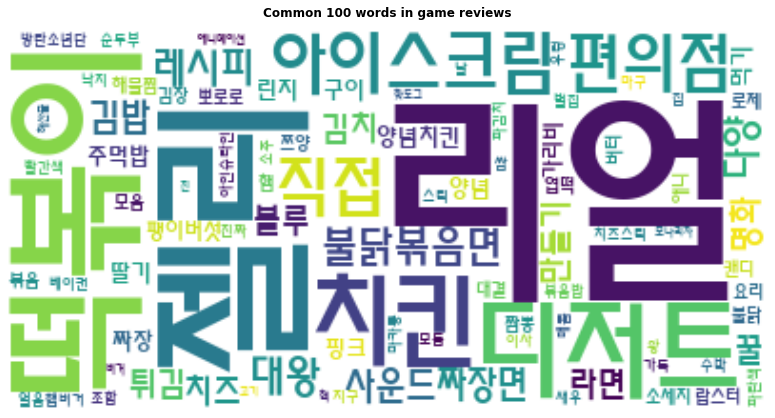

In [103]:
# Generate a word cloud
wordcloud.generate_from_frequencies(dict(word_count))
plt.figure(figsize= (20,7))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.title("Common 100 words in game reviews", pad = 14, weight = 'bold')
plt.show()

In [61]:
word_count[0:50]

먹방       118
리얼        34
도나        29
젤리        18
음식        15
떡볶이       13
디저트       11
치킨        10
아이스크림     10
불닭볶음면      9
직접         9
대왕         9
편의점        9
레시피        8
다양         7
짜장면        6
하이         6
김밥         6
사운드        6
블루         5
꿀          5
만들기        5
명화         5
까지         5
라면         5
치즈         5
김치         5
튀김         5
먹기         4
주먹밥        4
린지         4
팽이버섯       4
양념         4
짜장         4
양념치킨       4
구이         4
핑크         4
딸기         4
가리비        4
유의         3
버터         3
랍스터        3
햄          3
캔디         3
요리         3
볶음         3
쯔양         3
모음         3
엽떡         3
로제         3
dtype: int64

In [62]:
temp = pd.DataFrame(word_count, columns = ['count'])

stop_words = list(temp[temp['count']==1].reset_index(drop = False)['index'])

In [99]:
stop_words

['아주',
 '곱창',
 '병',
 '초밥',
 '황금',
 '제육',
 '로프',
 '숯불',
 '푸드파이터',
 '냉국',
 '해물짬뽕',
 '좔좔',
 '붕어싸만코',
 '한잔',
 '다가',
 '링클',
 '비시',
 '이유',
 '와인',
 '필수',
 '양상추',
 '립글로스',
 '불',
 '패티',
 '공화춘',
 '겉절이',
 '국',
 '오기',
 '무뼈',
 '즉석',
 '페양그',
 '자',
 '어몽',
 '축구공',
 '열라면',
 '스푼',
 '눈',
 '컵',
 '함',
 '고스트',
 '명',
 '라임',
 '시원',
 '혼자',
 '계란찜',
 '킬바사',
 '오이',
 '갈비',
 '드문',
 '기사',
 '퍼플',
 '올리브',
 '총각김치',
 '삼겹살',
 '주년',
 '요즘',
 '즌',
 '막국수',
 '시즌',
 '헐크',
 '헌터',
 '윤기',
 '표고버섯',
 '나시',
 '박스',
 '해명',
 '훈',
 '빵',
 '김치볶음밥',
 '찜',
 '오뚜기',
 '족발',
 '고소',
 '컵라면',
 '캣',
 '봄',
 '전복',
 '누룽지',
 '탕수육',
 '테일',
 '보틀',
 '알',
 '해장',
 '맥주',
 '실패',
 '눈알',
 '코하쿠토',
 '핫바',
 '갤럭시',
 '은퇴',
 '못',
 '명수',
 '꽃게탕',
 '새집',
 '호두',
 '요거트',
 '엘사',
 '주꾸미',
 '콜라',
 '데리',
 '샐러드',
 '이본',
 '허니콤',
 '입',
 '그린',
 '감스트',
 '귤',
 '레드',
 '크림',
 '구독',
 '쌈장',
 '골드바',
 '오징어',
 '진담',
 '음으로',
 '야끼소바',
 '처',
 '순대',
 '기념',
 '고추장',
 '수로',
 '끝판',
 '송이버섯',
 '바나나',
 '빌런',
 '레전드',
 '전구',
 '뿌',
 '닭발',
 '지니',
 '쭈꾸미',
 '내',
 '핫',
 '전',
 '인어공주',
 '맘대로',
 '진주',
 '다이어터',

In [98]:
stop_words.extend(['도나','먹방','음식','보','유','통','하이','유의','까지','유의'])

In [95]:
%%time
titles['tokens'] = titles['spell_check'].apply(lambda x: tokenization(x))

Wall time: 138 ms


In [96]:
titles

,title,cleaned_text,spell_check,tokens,token_len
0,Mukbang 짜장면 떡볶이 편의점 먹방 Convenience Store Food ...,Mukbang 짜장면 떡볶이 편의점 먹방 Convenience Store Food ...,Mukbang 짜장면 떡볶이 편의점 먹방 Convenience Store Food ...,"[짜장면, 떡볶이, 편의점]",5
1,Mukbang Bottle Candy Jelly 컬러 보틀 젤리 우유병 먹방 DON...,Mukbang Bottle Candy Jelly 컬러 보틀 젤리 우유병 먹방 DON...,Mukbang Bottle Candy Jelly 컬러 보틀 젤리 우유병 먹방 DON...,[젤리],7
2,Mukbang Spicy Giant Seafood 대왕 해산물 먹방 DONA 도나,Mukbang Spicy Giant Seafood 대왕 해산물 먹방 DONA 도나,Mukbang Spicy Giant Seafood 대왕 해산물 먹방 DONA 도나,"[대왕, 해산물]",4
3,짜장면 떡볶이 먹방 Black Noodle TTeokbokki Mukbang DON...,짜장면 떡볶이 먹방 Black Noodle TTeokbokki Mukbang DON...,짜장면 떡볶이 먹방 Black Noodle TTeokbokki Mukbang DON...,"[짜장면, 떡볶이]",4
4,명화 먹방 Famous painting MUkbang 모나리자 Mona Lisa,명화 먹방 Famous painting MUkbang 모나리자 Mona Lisa,명화 먹방 Famous painting MUkbang 모나리자 Mona Lisa,"[명화, 모나리자]",3
...,...,...,...,...,...
115,"리얼먹방:) 엽떡 로제떡볶이 ★ ft. 주먹밥, 핫도그ㅣRose Sauce Tteo...",리얼먹방 엽떡 로제떡볶이 ft 주먹밥 핫도그 Rose Sauce Tteokbokki...,리얼먹방 엽떡 로제떡볶이 ft 주먹밥 핫도그 Rose Sauce Tteokbokki...,"[리얼, 엽떡, 로제, 떡볶이, 주먹밥, 핫도그]",7
116,리얼먹방:) 쌀쌀할땐 꽃게탕 !! ★ ft. 붕어싸만코ㅣKkotge-tang (Sp...,리얼먹방 쌀쌀할땐 꽃게탕 ft 붕어싸만코 Kkotge tang Spicy Blue ...,리얼먹방 쌀쌀할땐 꽃게탕 ft 붕어싸만코 Kkotge tang Spicy Blue ...,[리얼],5
117,ASMR MUKBANG| 편의점 직접 만든 핵불닭 떡볶이 치킨 김밥 디저트 먹방 &...,ASMR MUKBANG| 편의점 직접 만든 핵불닭 떡볶이 치킨 김밥 디저트 먹방 레...,ASMR MUKBANG| 편의점 직접 만든 핵불닭 떡볶이 치킨 김밥 디저트 먹방 레...,"[편의점, 직접, 핵, 불닭, 떡볶이, 치킨, 김밥, 디저트, 레시피]",10
118,SUB)2주년 기념 딸기가득 딸기케이크 먹방!🥳🎂🍓수저로 마구마구 퍼먹기(ft.호두...,SUB 2주년 기념 딸기가득 딸기케이크 먹방 수저로 마구마구 퍼먹기 ft 호두빌런 ...,SUB 2주년 기념 딸기가득 딸기케이크 먹방 수저로 마구마구 퍼먹기 ft 호두빌런 ...,"[딸기, 가득, 딸기, 마구, 마구, 먹기]",13


In [97]:
word_list

['짜장면',
 '떡볶이',
 '편의점',
 '젤리',
 '대왕',
 '해산물',
 '짜장면',
 '떡볶이',
 '명화',
 '모나리자',
 '린지',
 '떡볶이',
 '젤리',
 '만들기',
 '불닭볶음면',
 '빨간색',
 '아이스크림',
 '린지',
 '방탄소년단',
 '',
 '직접',
 '불닭볶음면',
 '양념치킨',
 '소세지',
 '레시피',
 '유의',
 '대왕',
 '린지',
 '대왕',
 '지구',
 '젤리',
 '젤리',
 '캔디',
 '대결',
 '핑크',
 '디저트',
 '불닭볶음면',
 '뽀로로',
 '짜장면',
 '젤리',
 '대왕',
 '랍스터',
 '해물찜',
 '치킨',
 '진짜',
 '린지',
 '짜장면',
 '떡볶이',
 '편의점',
 '',
 '라면',
 '',
 '',
 '아이스크림',
 '',
 '짜장',
 '불닭',
 '팽이버섯',
 '낙지',
 '집',
 '엽떡',
 '로제',
 '떡볶이',
 '베이컨',
 '주먹밥',
 '핫도그',
 '버터',
 '유의',
 '리얼',
 '얼음',
 '젤리',
 '캔디',
 '빨간색',
 '대결',
 '애니메이션',
 '다양',
 '블루',
 '핑크',
 '아이스크림',
 '젤리',
 '양념',
 '치킨',
 '짜장',
 '팽이버섯',
 '편의점',
 '대왕',
 '뽀로로',
 '떡볶이',
 '리얼',
 '라면',
 '디저트',
 '요리',
 '짜장',
 '해물찜',
 '랍스터',
 '새우',
 '가리비',
 '팽이버섯',
 '명화',
 '파란색',
 '얼음',
 '리얼',
 '햄',
 '요리',
 '모음',
 '수박',
 '아이스크림',
 '젤리',
 '수박',
 '캔디',
 '대왕',
 '해산물',
 '치즈',
 '치킨',
 '햄버거',
 '치킨',
 '버거',
 '튀김',
 '치즈스틱',
 '까지',
 '리얼',
 '사운드',
 '다양',
 '블루',
 '디저트',
 '아인슈타인',
 '명화',
 '방탄소년단',
 '왕',
 '치킨',
 '치즈스틱',
 '새우',
 '스틱',

In [105]:
from nltk.util import everygrams
list(everygrams(titles['tokens'][21], min_len =2, max_len = 2))

[('대왕', '랍스터'), ('랍스터', '해물찜')]

In [107]:
%%time
titles['bi_gram'] = titles['tokens'].apply(lambda x: ["_".join(i) for i in list(everygrams(x, min_len =1, max_len = 2))])

Wall time: 998 µs


In [111]:
titles

,title,cleaned_text,spell_check,tokens,token_len,bi_gram
0,Mukbang 짜장면 떡볶이 편의점 먹방 Convenience Store Food ...,Mukbang 짜장면 떡볶이 편의점 먹방 Convenience Store Food ...,Mukbang 짜장면 떡볶이 편의점 먹방 Convenience Store Food ...,"[짜장면, 떡볶이, 편의점]",5,"[짜장면, 짜장면_떡볶이, 떡볶이, 떡볶이_편의점, 편의점]"
1,Mukbang Bottle Candy Jelly 컬러 보틀 젤리 우유병 먹방 DON...,Mukbang Bottle Candy Jelly 컬러 보틀 젤리 우유병 먹방 DON...,Mukbang Bottle Candy Jelly 컬러 보틀 젤리 우유병 먹방 DON...,[젤리],7,[젤리]
2,Mukbang Spicy Giant Seafood 대왕 해산물 먹방 DONA 도나,Mukbang Spicy Giant Seafood 대왕 해산물 먹방 DONA 도나,Mukbang Spicy Giant Seafood 대왕 해산물 먹방 DONA 도나,"[대왕, 해산물]",4,"[대왕, 대왕_해산물, 해산물]"
3,짜장면 떡볶이 먹방 Black Noodle TTeokbokki Mukbang DON...,짜장면 떡볶이 먹방 Black Noodle TTeokbokki Mukbang DON...,짜장면 떡볶이 먹방 Black Noodle TTeokbokki Mukbang DON...,"[짜장면, 떡볶이]",4,"[짜장면, 짜장면_떡볶이, 떡볶이]"
4,명화 먹방 Famous painting MUkbang 모나리자 Mona Lisa,명화 먹방 Famous painting MUkbang 모나리자 Mona Lisa,명화 먹방 Famous painting MUkbang 모나리자 Mona Lisa,"[명화, 모나리자]",3,"[명화, 명화_모나리자, 모나리자]"
...,...,...,...,...,...,...
115,"리얼먹방:) 엽떡 로제떡볶이 ★ ft. 주먹밥, 핫도그ㅣRose Sauce Tteo...",리얼먹방 엽떡 로제떡볶이 ft 주먹밥 핫도그 Rose Sauce Tteokbokki...,리얼먹방 엽떡 로제떡볶이 ft 주먹밥 핫도그 Rose Sauce Tteokbokki...,"[리얼, 엽떡, 로제, 떡볶이, 주먹밥, 핫도그]",7,"[리얼, 리얼_엽떡, 엽떡, 엽떡_로제, 로제, 로제_떡볶이, 떡볶이, 떡볶이_주먹..."
116,리얼먹방:) 쌀쌀할땐 꽃게탕 !! ★ ft. 붕어싸만코ㅣKkotge-tang (Sp...,리얼먹방 쌀쌀할땐 꽃게탕 ft 붕어싸만코 Kkotge tang Spicy Blue ...,리얼먹방 쌀쌀할땐 꽃게탕 ft 붕어싸만코 Kkotge tang Spicy Blue ...,[리얼],5,[리얼]
117,ASMR MUKBANG| 편의점 직접 만든 핵불닭 떡볶이 치킨 김밥 디저트 먹방 &...,ASMR MUKBANG| 편의점 직접 만든 핵불닭 떡볶이 치킨 김밥 디저트 먹방 레...,ASMR MUKBANG| 편의점 직접 만든 핵불닭 떡볶이 치킨 김밥 디저트 먹방 레...,"[편의점, 직접, 핵, 불닭, 떡볶이, 치킨, 김밥, 디저트, 레시피]",10,"[편의점, 편의점_직접, 직접, 직접_핵, 핵, 핵_불닭, 불닭, 불닭_떡볶이, 떡..."
118,SUB)2주년 기념 딸기가득 딸기케이크 먹방!🥳🎂🍓수저로 마구마구 퍼먹기(ft.호두...,SUB 2주년 기념 딸기가득 딸기케이크 먹방 수저로 마구마구 퍼먹기 ft 호두빌런 ...,SUB 2주년 기념 딸기가득 딸기케이크 먹방 수저로 마구마구 퍼먹기 ft 호두빌런 ...,"[딸기, 가득, 딸기, 마구, 마구, 먹기]",13,"[딸기, 딸기_가득, 가득, 가득_딸기, 딸기, 딸기_마구, 마구, 마구_마구, 마..."
